In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [5]:
# Dataset columns

columns = ['S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5', 'Class']

# Load your dataset
training_data = pd.read_csv('poker-hand-training-true.csv', header=None, names=columns)
testing_data = pd.read_csv('poker-hand-testing.csv', header=None, names=columns)

# Adjust the ranks of cards, specifically changing Ace from 1 to 14
def adjust_ranks(data):
    for i in range(1, 6):  # For each card in the hand
        data[f'C{i}'] = data[f'C{i}'].apply(lambda x: 14 if x == 1 else x)
    return data

# One-hot encode the suits of the cards
def one_hot_encode_suits(data):
    for i in range(1, 6):  # For each card in the hand
        data = pd.concat([data, pd.get_dummies(data[f'S{i}'], prefix=f'S{i}')], axis=1).drop([f'S{i}'], axis=1)
    return data

# Make all rows with classes 0-3 to be 0, 4-6 to be 1, and 7-9 to be 2
def adjust_classes(data):
    data['Class'] = data['Class'].apply(lambda x: 0 if x < 4 else 1 if x < 7 else 2)
    return data

# Apply preprocessing steps
def preprocess_data(data):
    data = adjust_ranks(data)
    data = one_hot_encode_suits(data)
    data = adjust_classes(data)
    return data

training_data_preprocessed = preprocess_data(training_data)
testing_data_preprocessed = preprocess_data(testing_data)

# Split training and test data to just have the combinations where classes are 0,1 0,2 and 1,2
training_data_preprocessed_01 = training_data_preprocessed[training_data_preprocessed['Class'] != 2]
testing_data_preprocessed_01 = testing_data_preprocessed[testing_data_preprocessed['Class'] != 2]

training_data_preprocessed_02 = training_data_preprocessed[training_data_preprocessed['Class'] != 1]
testing_data_preprocessed_02 = testing_data_preprocessed[testing_data_preprocessed['Class'] != 1]

training_data_preprocessed_12 = training_data_preprocessed[training_data_preprocessed['Class'] != 0]
testing_data_preprocessed_12 = testing_data_preprocessed[testing_data_preprocessed['Class'] != 0]

# X_train, X_val, y_train, y_val = train_test_split(training_data_preprocessed.drop('Class', axis=1).to_numpy(), training_data_preprocessed['Class'].to_numpy(), test_size=0.1, random_state=42)

#Final Preprocessed DATA
print(training_data_preprocessed.head())
print(testing_data_preprocessed.head())

   C1  C2  C3  C4  C5  Class  S1_1  S1_2  S1_3  S1_4  ...  S3_3  S3_4  S4_1  \
0  10  11  13  12  14      2     1     0     0     0  ...     0     0     1   
1  11  13  10  12  14      2     0     1     0     0  ...     0     0     0   
2  12  11  13  10  14      2     0     0     1     0  ...     1     0     0   
3  10  11  14  13  12      2     0     0     0     1  ...     0     1     0   
4  14  13  12  11  10      2     0     0     0     1  ...     0     1     0   

   S4_2  S4_3  S4_4  S5_1  S5_2  S5_3  S5_4  
0     0     0     0     1     0     0     0  
1     1     0     0     0     1     0     0  
2     0     1     0     0     0     1     0  
3     0     0     1     0     0     0     1  
4     0     0     1     0     0     0     1  

[5 rows x 26 columns]
   C1  C2  C3  C4  C5  Class  S1_1  S1_2  S1_3  S1_4  ...  S3_3  S3_4  S4_1  \
0  14  13   4   3  12      0     1     0     0     0  ...     0     0     0   
1  12   2  11   5   5      0     0     0     1     0  ...     1     

Best parameters: {'kernel': 'linear'}
Best cross-validated score:  0.9926782475342607
   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_kernel  \
0       0.336742      0.004986         0.064831        0.000572       linear   
1       1.563370      0.109379         0.088698        0.002504         poly   
2       0.740765      0.039731         0.335576        0.015668          rbf   
3       0.138792      0.003249         0.029917        0.002541      sigmoid   

                  params  split0_test_score  split1_test_score  \
0   {'kernel': 'linear'}           0.992799           0.992599   
1     {'kernel': 'poly'}           0.992799           0.992599   
2      {'kernel': 'rbf'}           0.992799           0.992599   
3  {'kernel': 'sigmoid'}           0.991598           0.990998   

   split2_test_score  split3_test_score  split4_test_score  mean_test_score  \
0           0.992599           0.992599           0.992797         0.992678   
1           0.992599    

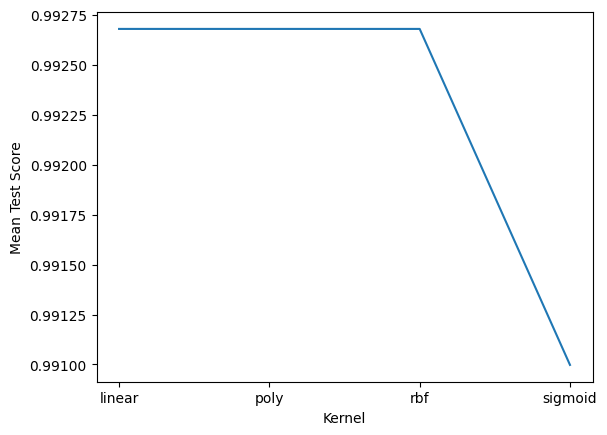

In [9]:
# perform 5-fold cross validation on the training dataset on the binary classification problem of class 0 versus 1
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}
clf = SVC()
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(training_data_preprocessed_01.drop('Class', axis=1), training_data_preprocessed_01['Class'])

print("Best parameters:", grid_search.best_params_)
print("Best cross-validated score: ", grid_search.best_score_)

# plotting results
results = pd.DataFrame(grid_search.cv_results_)
print(results)

# bar chart of results for each kernel
fig, ax = plt.subplots()
ax.plot(results['param_kernel'], results['mean_test_score'])

ax.set_xlabel('Kernel')
ax.set_ylabel('Mean Test Score')
plt.show()

# get best kernel
best_kernel = grid_search.best_params_['kernel']

In [10]:
# train the model on the training dataset with the best kernel and evaluate it on the test dataset
clf = SVC(kernel=best_kernel, C=1, gamma=0.1)
clf.fit(training_data_preprocessed_01.drop('Class', axis=1), training_data_preprocessed_01['Class'])
# predicted_labels = clf.predict(testing_data_preprocessed_01.drop('Class', axis=1).to_numpy())
accuracy = clf.score(testing_data_preprocessed_01.drop('Class', axis=1), testing_data_preprocessed_01['Class'])
print(f'Accuracy on test data for class 0 versus 1: {accuracy}')

Accuracy on test data for class 0 versus 1: 0.99269320983641


Best parameters: {'kernel': 'linear'}
Best cross-validated score:  0.999355545199806
   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_kernel  \
0       0.095184      0.003749         0.020079        0.000593       linear   
1       0.163064      0.025448         0.011103        0.000879         poly   
2       0.086979      0.004806         0.045961        0.002666          rbf   
3       0.023134      0.001039         0.005263        0.000213      sigmoid   

                  params  split0_test_score  split1_test_score  \
0   {'kernel': 'linear'}           0.999195           0.999396   
1     {'kernel': 'poly'}           0.999195           0.999396   
2      {'kernel': 'rbf'}           0.999195           0.999396   
3  {'kernel': 'sigmoid'}           0.999195           0.999396   

   split2_test_score  split3_test_score  split4_test_score  mean_test_score  \
0           0.999396           0.999396           0.999396         0.999356   
1           0.999396     

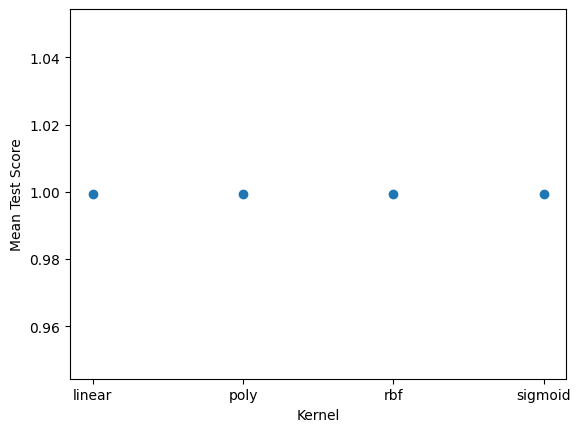

In [11]:
# perform 5-fold cross validation on the training dataset on the binary classification problem of class 0 versus 2
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}
clf = SVC()
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(training_data_preprocessed_02.drop('Class', axis=1), training_data_preprocessed_02['Class'])

print("Best parameters:", grid_search.best_params_)
print("Best cross-validated score: ", grid_search.best_score_)

# plotting results
results = pd.DataFrame(grid_search.cv_results_)
print(results)

# scatter plot of results for each kernel
fig, ax = plt.subplots()
ax.scatter(results['param_kernel'], results['mean_test_score'])

ax.set_xlabel('Kernel')
ax.set_ylabel('Mean Test Score')
plt.show()

# get best kernel
best_kernel = grid_search.best_params_['kernel']

In [12]:
# train the model on the training dataset with the best kernel and evaluate it on the test dataset
clf = SVC(kernel=best_kernel, C=1, gamma=0.1)
clf.fit(training_data_preprocessed_02.drop('Class', axis=1), training_data_preprocessed_02['Class'])
accuracy = clf.score(testing_data_preprocessed_02.drop('Class', axis=1), testing_data_preprocessed_02['Class'])
print(f'Accuracy on test data for class 0 versus 2: {accuracy}')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Accuracy on test data for class 0 versus 2: 0.9997531971048509


Best parameters: {'kernel': 'linear'}
Best cross-validated score:  0.9196153846153846
   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_kernel  \
0       0.001842      0.000428         0.000778        0.000069       linear   
1       0.001389      0.000147         0.000607        0.000060         poly   
2       0.000921      0.000043         0.000660        0.000049          rbf   
3       0.000783      0.000053         0.000524        0.000015      sigmoid   

                  params  split0_test_score  split1_test_score  \
0   {'kernel': 'linear'}                0.9              0.925   
1     {'kernel': 'poly'}                0.9              0.925   
2      {'kernel': 'rbf'}                0.9              0.925   
3  {'kernel': 'sigmoid'}                0.9              0.925   

   split2_test_score  split3_test_score  split4_test_score  mean_test_score  \
0              0.925              0.925           0.923077         0.919615   
1              0.925    

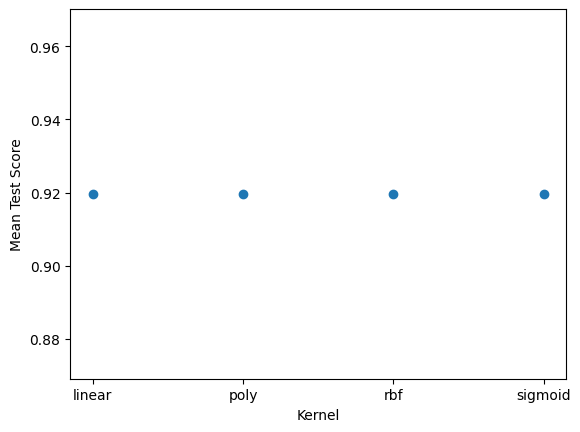

In [13]:
# perform 5-fold cross validation on the training dataset on the binary classification problem of class 1 versus 2
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}
clf = SVC()
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(training_data_preprocessed_12.drop('Class', axis=1), training_data_preprocessed_12['Class'])

print("Best parameters:", grid_search.best_params_)
print("Best cross-validated score: ", grid_search.best_score_)

# plotting results
results = pd.DataFrame(grid_search.cv_results_)
print(results)

# scatter plot of results for each kernel
fig, ax = plt.subplots()
ax.scatter(results['param_kernel'], results['mean_test_score'])

ax.set_xlabel('Kernel')
ax.set_ylabel('Mean Test Score')
plt.show()

# get best kernel
best_kernel = grid_search.best_params_['kernel']

In [14]:
# train the model on the training dataset with the best kernel and evaluate it on the test dataset for class 1 versus 2
clf = SVC(kernel=best_kernel, C=1, gamma=0.1)
clf.fit(training_data_preprocessed_12.drop('Class', axis=1), training_data_preprocessed_12['Class'])
accuracy = clf.score(testing_data_preprocessed_12.drop('Class', axis=1), testing_data_preprocessed_12['Class'])
print(f'Accuracy on test data for class 0 versus 2: {accuracy}')

Accuracy on test data for class 0 versus 2: 0.9675496688741722
